In [285]:
import numpy as np
import pandas as pd
import sys
sys.path.append('../')
from utils.fehler_gauss import fehler_gauss, weighted_mean
from sympy import *
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

## Linsentypen

- A Sammellinse
- B Sammellinse
- G Sammellinse
- E Streulinse

## Allgemeine Settings

In [286]:
pos_lampe = 0e-2
u_pos_lampe = 0.1e-2

pos_linse_a = 5e-2
u_pos_linse_a = 0.1e-2

pos_gitter = 20e-2
u_pos_gitter = 0.1e-2

## Autokollimationsmethode Einfachlinsen

Brennweite: $f' = \frac{k + l -h}{2} \approx \frac{k + l}{2}$

In [287]:
d_linse_spiegel = 3e-2
u_d_linse_spiegel = 0.1e-2

autokoll_einfach = pd.read_excel("OPA.xlsx", sheet_name="AutokollimationEinfachlinsen") * 1e-2 # importieren in meter
u_autokoll_einfach = 0.3e-2 # ableseunsicherheit in meter

k = autokoll_einfach - pos_gitter # abstand gitter - bildschirm
l = k # abstand gitter - bildschirm umgedreht (nutzen einfach das Gleiche weil Gangsta)

In [288]:
# Typ A Unsicherheiten für die Abstände (korrigiert mit Student-t Verteilung)
u_k_typ_a = k.std(ddof=1) * 0.51
u_l_typ_a = l.std(ddof=1) * 0.51

# Gaussche Fehlerfortpflanzung für die Brennweite
k_symbol, l_symbol = symbols("k l")
brennweite_formula = (k_symbol + l_symbol) / 2
brennweite_formula

k/2 + l/2

In [289]:
gesamtunsicherheit_k = np.sqrt(u_k_typ_a**2 + u_autokoll_einfach**2)
gesamtunsicherheit_l = np.sqrt(u_l_typ_a**2 + u_autokoll_einfach**2)

brennweite, u_brennweite = fehler_gauss(
    brennweite_formula,
    [k_symbol, l_symbol],
    [k.mean(), l.mean()],
    [gesamtunsicherheit_k, gesamtunsicherheit_l],
)
brennweite * 1e2 # brennweite in cm

G     7.50
B    10.18
dtype: float64

In [290]:
u_brennweite * 1e2 # unsicherheit in cm

G    0.215176
B    0.214267
dtype: float64

## Besselmethode Einfachlinsen

$e = -a_1 + h + d + a_2' = -a_2 + h - d + a_1' = b_k - g_k$

$b_k$ Position Schirm beim kleinen Bild

$g$ Position Gitter

$d = l_k - l_g$ Abstand zwischen den rechten Hauptebenen von kleinem zu großem Bild

$l_k$ Position der Linse beim kleinen Bild

$l_g$ Position der Linse beim großen Bild

Brennweite $f' = \frac{1}{4} \cdot \left[(e - h) - \frac{d^2}{e - h} \right] \approx \frac{1}{4} \cdot \left[e - \frac{d^2}{e}\right]$ (dünne Linse)

In [291]:
gittergroesse = 5e-3
u_gittergroesse = 0.1e-2

gittergroesse_schirm = 20e-3
u_gittergroesse_schirm = 0.1e-3

g_pos_schirm = 69.5e-2
u_g_pos_schirm = 0.1e-2

e_pos_schirm = 84.1e-2
u_e_pos_schirm = 0.1e-2

bessel_einfach = pd.read_excel("OPA.xlsx", sheet_name="BesselEinfachlinsen") * 1e-2 # in meter
bessel_einfach

,G gross,G klein,E gross,E klein
0,0.294,0.611,0.329,0.720
1,0.294,0.609,0.325,0.719
2,0.291,0.608,0.329,0.720
3,0.292,0.606,0.327,0.722
4,0.293,0.608,0.325,0.720


In [292]:
# gausssche Fehlerfortpflanzung für die Brennweite
b_k_symbol, g_symbol = symbols("b_k g")
e = b_k_symbol - g_symbol

l_k_symbol, l_g_symbol = symbols("l_k l_g")
d = l_k_symbol - l_g_symbol

brennweite_formula = 1/4 * (e - d**2/e)
brennweite_formula

0.25*b_k - 0.25*g - 0.25*(-l_g + l_k)**2/(b_k - g)

In [293]:
# Bessel für Linse G
brennweiten_g, u_brennweiten_g = fehler_gauss(
    brennweite_formula,
    [b_k_symbol, g_symbol, l_k_symbol, l_g_symbol],
    [
        g_pos_schirm,
        pos_gitter,
        bessel_einfach["G klein"],
        bessel_einfach["G gross"],
    ],
    [u_g_pos_schirm, u_pos_gitter, 5e-3, 5e-3],
)
brennweite_g, u_brennweite_g = weighted_mean(brennweiten_g, u_brennweiten_g)
brennweite_g * 1e2, u_brennweite_g * 1e2 # Ergebnisse in cm

(np.float64(7.344739640914351), np.float64(0.10323126960090592))

In [294]:
# Bessel für Linse E
brennweiten_e, u_brennweiten_e = fehler_gauss(
    brennweite_formula,
    [b_k_symbol, g_symbol, l_k_symbol, l_g_symbol],
    [
        e_pos_schirm,
        pos_gitter,
        bessel_einfach["E klein"],
        bessel_einfach["E gross"],
    ],
    [u_e_pos_schirm, u_pos_gitter, 5e-3, 5e-3],
)
brennweite_e, u_brennweite_e = weighted_mean(brennweiten_e, u_brennweiten_e)
brennweite_e * 1e2, u_brennweite_e * 1e2 # Ergebnisse in cm

(np.float64(9.995497858863873), np.float64(0.0993978008322837))

## Brennweite und Hauptebenenabstand Linsensystem mit Kombination aus Autokollimation und Bessel

$p_{12}$ Absolutposition von Linse G

### Autokollimation

$k = p_1 - g$

$l = p_2 - g$

### Besselmethode

$e = b_k - g$

$d = l_k - l_g$

### Insgesamt

$f' = \frac{1}{2} \sqrt{(e - k - l)^2 - d^2}$

$h = k + l - \sqrt{(e - k - l)^2 - d^2}$

In [295]:
autokoll_linsensystem = pd.read_excel("OPA.xlsx", sheet_name="AutokollimationLinsensystem") * 1e-2 # in meter
autokoll_linsensystem

,G-E-Spiegel,E-G-Spiegel
0,0.366,0.308
1,0.365,0.306
2,0.367,0.308
3,0.366,0.305
4,0.367,0.306


In [296]:
g_e_pos_schirm = 107.5e-2
u_g_e_pos_schirm = 0.1e-2

e_g_pos_schirm = 104.6e-2
u_e_g_pos_schirm = 0.1e-2

bessel_linsensystem = pd.read_excel("OPA.xlsx", sheet_name="BesselLinsensystem") * 1e-2 # in meter
bessel_linsensystem

,G-E-gross,G-E-klein,E-G-gross,E-G-klein
0,0.392,0.941,0.339,0.847
1,0.391,0.944,0.342,0.848
2,0.393,0.940,0.342,0.851
3,0.394,0.940,0.337,0.851
4,0.394,0.944,0.341,0.850


In [297]:
# fehler gauss
e_symbol, d_symbol, k_symbol, l_symbol = symbols("e d k l")
brennweite_formula = 1/2 * sqrt((e_symbol - k_symbol - l_symbol)**2 - d_symbol**2)
brennweite_formula

0.5*sqrt(-d**2 + (e - k - l)**2)

In [298]:
h_formula = k_symbol + l_symbol - sqrt((e_symbol - k_symbol - l_symbol)**2 - d_symbol**2)
h_formula

k + l - sqrt(-d**2 + (e - k - l)**2)

In [299]:
k = autokoll_linsensystem["E-G-Spiegel"] - pos_gitter
u_k = np.sqrt((k.std(ddof=1) * 0.51)**2 + 5e-3**2 + 1e-3**2) # Unsicherheit k mit Typ A und Ableseunsicherheit
k = k.mean()

l = autokoll_linsensystem["G-E-Spiegel"] - pos_gitter
u_l = np.sqrt((l.std(ddof=1) * 0.51)**2 + 5e-3**2 + 1e-3**2) # Unsicherheit l mit Typ A und Ableseunsicherheit
l = l.mean()

e = e_g_pos_schirm - pos_gitter
u_e = np.sqrt((u_e_g_pos_schirm)**2 + u_pos_gitter**2)

# Abstand zwischen den scharfen Bildern in der Besselmethode für beide Konfigurationen
d1 = bessel_linsensystem["G-E-klein"] - bessel_linsensystem["G-E-gross"]
u_d1 = np.sqrt((5e-3)**2 + (5e-3)**2 + d1.std(ddof=1)**2 * 0.51**2)
d1 = d1.mean()

d2 = bessel_linsensystem["G-E-klein"] - bessel_linsensystem["G-E-gross"]
u_d2 = np.sqrt((5e-3)**2 + (5e-3)**2 + d2.std(ddof=1)**2 * 0.51**2)
d2 = d2.mean()

# Brennweiten für beide Konfigurationen
brennweite_1, u_brennweite_1 = fehler_gauss(
    brennweite_formula,
    [e_symbol, d_symbol, k_symbol, l_symbol],
    [e, d1, k, l],
    [u_e, u_d1, u_k, u_l],
)
print(f"G-E-Schirm: {brennweite_1 * 1e2, u_brennweite_1 * 1e2}")

brennweite_2, u_brennweite_2 = fehler_gauss(
    brennweite_formula,
    [e_symbol, d_symbol, k_symbol, l_symbol],
    [e, d2, k, l],
    [u_e, u_d2, u_k, u_l],
)
print(f"E-G-Schirm: {brennweite_2 * 1e2, u_brennweite_2 * 1e2}")

# Gewichteter Mittelwert
brennweiten = np.array([brennweite_1, brennweite_2])
u_brennweiten = np.array([u_brennweite_1, u_brennweite_2])
brennweite, u_brennweite = weighted_mean(brennweiten, u_brennweiten)
print(f"Gewichteter Mittelwert: {brennweite * 1e2, u_brennweite * 1e2}")

G-E-Schirm: (np.float64(8.239726937223105), np.float64(1.7590815834338327))
E-G-Schirm: (np.float64(8.239726937223105), np.float64(1.7590815834338327))
Gewichteter Mittelwert: (np.float64(8.239726937223105), np.float64(1.2438585163064326))


In [300]:
h_1, u_h_1 = fehler_gauss(
    h_formula,
    [e_symbol, d_symbol, k_symbol, l_symbol],
    [e, d1, k, l],
    [u_e, u_d1, u_k, u_l],
)
print(f"G-E-Schirm: {h_1 * 1e2, u_h_1 * 1e2}")

h_2, u_h_2 = fehler_gauss(
    h_formula,
    [e_symbol, d_symbol, k_symbol, l_symbol],
    [e, d2, k, l],
    [u_e, u_d2, u_k, u_l],
)
print(f"E-G-Schirm: {h_2 * 1e2, u_h_2 * 1e2}")

# Gewichteter Mittelwert
hs = np.array([h_1, h_2])
u_hs = np.array([u_h_1, u_h_2])
h, u_h = weighted_mean(hs, u_hs)
print(f"Gewichteter Mittelwert: {h * 1e2, u_h * 1e2}")

G-E-Schirm: (np.float64(10.800546125553792), np.float64(4.070210179739371))
E-G-Schirm: (np.float64(10.800546125553792), np.float64(4.070210179739371))
Gewichteter Mittelwert: (np.float64(10.800546125553792), np.float64(2.8780732189482254))


## Abbeverfahren Linsensysteme

In [368]:
abbe_e_g = pd.read_excel("OPA.xlsx", sheet_name="AbbeE-G-Schirm")
abbe_e_g[["Vergroesserung", "Verkleinerung"]] *= -1e-3
abbe_e_g[["Schirm", "Position G", "Position G.1"]] *= 1e-2
abbe_e_g["g_Vergroesserung"] = abbe_e_g["Position G"] - pos_gitter
abbe_e_g["g_Verkleinerung"] = abbe_e_g["Position G.1"] - pos_gitter

abbe_e_g["g'_Vergroesserung"] = abbe_e_g["Schirm"] - abbe_e_g["Position G"]
abbe_e_g["g'_Verkleinerung"] = abbe_e_g["Schirm"] - abbe_e_g["Position G.1"]

abbe_e_g

,Schirm,Vergroesserung,Position G,Verkleinerung,Position G.1,g_Vergroesserung,g_Verkleinerung,g'_Vergroesserung,g'_Verkleinerung
0,1.50,-0.03440,0.330,-0.00100,1.321,0.130,1.121,1.170,0.179
1,1.25,-0.02455,0.327,-0.00100,1.061,0.127,0.861,0.923,0.189
2,1.00,-0.01760,0.334,-0.00135,0.799,0.134,0.599,0.666,0.201
3,0.75,-0.00765,0.380,-0.00320,0.521,0.180,0.321,0.370,0.229


In [369]:
abbe_g_e = pd.read_excel("OPA.xlsx", sheet_name="AbbeG-E-Schirm")
abbe_g_e[["Vergroesserung", "Verkleinerung"]] *= -1e-3
abbe_g_e[["Schirm", "Position G", "Position G.1"]] *= 1e-2
abbe_g_e["g_Vergroesserung"] = abbe_g_e["Position G"] - pos_gitter
abbe_g_e["g_Verkleinerung"] = abbe_g_e["Position G.1"] - pos_gitter

abbe_g_e["g'_Vergroesserung"] = abbe_g_e["Schirm"] - abbe_g_e["Position G"]
abbe_g_e["g'_Verkleinerung"] = abbe_g_e["Schirm"] - abbe_g_e["Position G.1"]

abbe_g_e

,Schirm,Vergroesserung,Position G,Verkleinerung,Position G.1,g_Vergroesserung,g_Verkleinerung,g'_Vergroesserung,g'_Verkleinerung
0,1.50,-0.03375,0.395,-0.0015,1.377,0.195,1.177,1.105,0.123
1,1.25,-0.02545,0.385,-0.0015,1.121,0.185,0.921,0.865,0.129
2,1.00,-0.01745,0.402,-0.0015,0.856,0.202,0.656,0.598,0.144
3,0.75,-0.00815,0.448,-0.0033,0.563,0.248,0.363,0.302,0.187


In [370]:
groesse_gitter = 5e-3
u_groesse_gitter = 0.1e-3

In [371]:
# Vergrößerungen / Verkleinerungen mit Unsicherheiten bestimmen
y_symbol, yp_symbol = symbols("y y'")
beta = yp_symbol / y_symbol
beta

y'/y

In [372]:
for category in ["Vergroesserung", "Verkleinerung"]:
    for df in [abbe_e_g, abbe_g_e]:
        beta_verkleinerung, u_beta_verkleinerung = fehler_gauss(
            beta,
            [y_symbol, yp_symbol],
            [groesse_gitter, df[category]],
            [u_groesse_gitter, 1e-3],
        )
        df[f"beta_{category}"] = beta_verkleinerung
        df[f"u_beta_{category}"] = u_beta_verkleinerung

abbe_g_e

,Schirm,Vergroesserung,Position G,Verkleinerung,Position G.1,g_Vergroesserung,g_Verkleinerung,g'_Vergroesserung,g'_Verkleinerung,beta_Vergroesserung,u_beta_Vergroesserung,beta_Verkleinerung,u_beta_Verkleinerung
0,1.50,-0.03375,0.395,-0.0015,1.377,0.195,1.177,1.105,0.123,-6.75,0.241299,-0.30,0.200090
1,1.25,-0.02545,0.385,-0.0015,1.121,0.185,0.921,0.865,0.129,-5.09,0.224418,-0.30,0.200090
2,1.00,-0.01745,0.402,-0.0015,0.856,0.202,0.656,0.598,0.144,-3.49,0.211830,-0.30,0.200090
3,0.75,-0.00815,0.448,-0.0033,0.563,0.248,0.363,0.302,0.187,-1.63,0.202639,-0.66,0.200435


In [373]:
# 1 - 1/beta berechnen mit Unsicherheiten
beta_symbol = symbols("beta")
regression1_formula = 1 - 1/beta_symbol
regression1_formula

1 - 1/beta

In [374]:
regression2_formula = 1 - beta_symbol
regression2_formula

1 - beta

In [375]:
for df in [abbe_e_g, abbe_g_e]:
    for category in ["Vergroesserung", "Verkleinerung"]:
        regression1_val, u_regression1 = fehler_gauss(
            regression1_formula,
            [beta_symbol],
            [df[f"beta_{category}"]],
            [df[f"u_beta_{category}"]]
        )
        df[f"1-1/beta_{category}"] = regression1_val
        df[f"u_1-1/beta_{category}"] = u_regression1

        regression2_val, u_regression2 = fehler_gauss(
            regression2_formula,
            [beta_symbol],
            [df[f"beta_{category}"]],
            [df[f"u_beta_{category}"]]
        )
        df[f"1-beta_{category}"] = regression2_val
        df[f"u_1-beta_{category}"] = u_regression2

abbe_g_e

,Schirm,Vergroesserung,Position G,Verkleinerung,Position G.1,g_Vergroesserung,g_Verkleinerung,g'_Vergroesserung,g'_Verkleinerung,beta_Vergroesserung,...,beta_Verkleinerung,u_beta_Verkleinerung,1-1/beta_Vergroesserung,u_1-1/beta_Vergroesserung,1-beta_Vergroesserung,u_1-beta_Vergroesserung,1-1/beta_Verkleinerung,u_1-1/beta_Verkleinerung,1-beta_Verkleinerung,u_1-beta_Verkleinerung
0,1.50,-0.03375,0.395,-0.0015,1.377,0.195,1.177,1.105,0.123,-6.75,...,-0.30,0.200090,1.148148,0.005296,7.75,0.241299,4.333333,2.223222,1.30,0.200090
1,1.25,-0.02545,0.385,-0.0015,1.121,0.185,0.921,0.865,0.129,-5.09,...,-0.30,0.200090,1.196464,0.008662,6.09,0.224418,4.333333,2.223222,1.30,0.200090
2,1.00,-0.01745,0.402,-0.0015,0.856,0.202,0.656,0.598,0.144,-3.49,...,-0.30,0.200090,1.286533,0.017392,4.49,0.211830,4.333333,2.223222,1.30,0.200090
3,0.75,-0.00815,0.448,-0.0033,0.563,0.248,0.363,0.302,0.187,-1.63,...,-0.66,0.200435,1.613497,0.076269,2.63,0.202639,2.515152,0.460136,1.66,0.200435


------------------------------------------------
E-G
f = 0.11 +- 0.02
h1 = 0.00 +- 0.02
f' = 0.15 +- 0.01
h2 = -0.01 +- 0.04


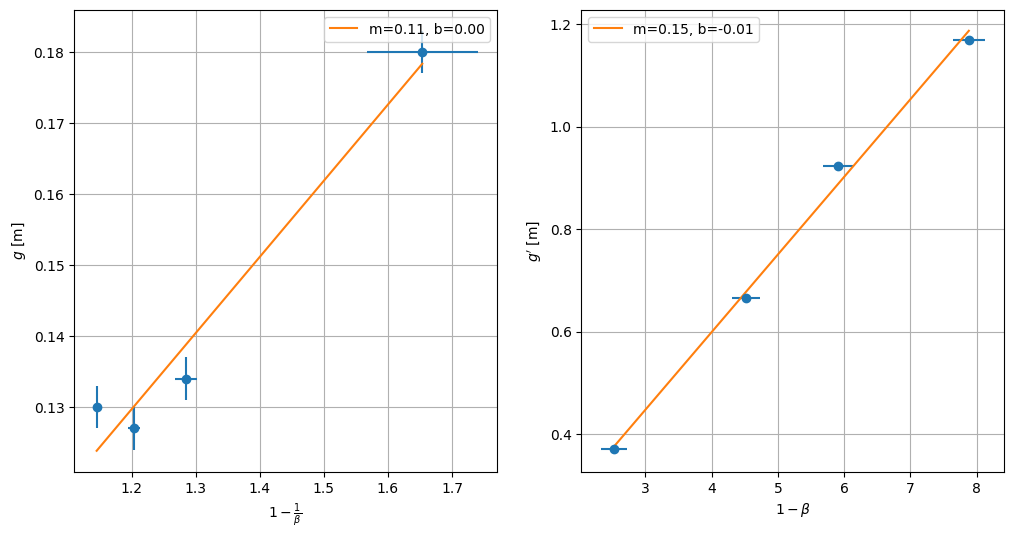

------------------------------------------------
G-E
f = 0.13 +- 0.02
h1 = 0.04 +- 0.03
f' = 0.16 +- 0.00
h2 = -0.11 +- 0.02


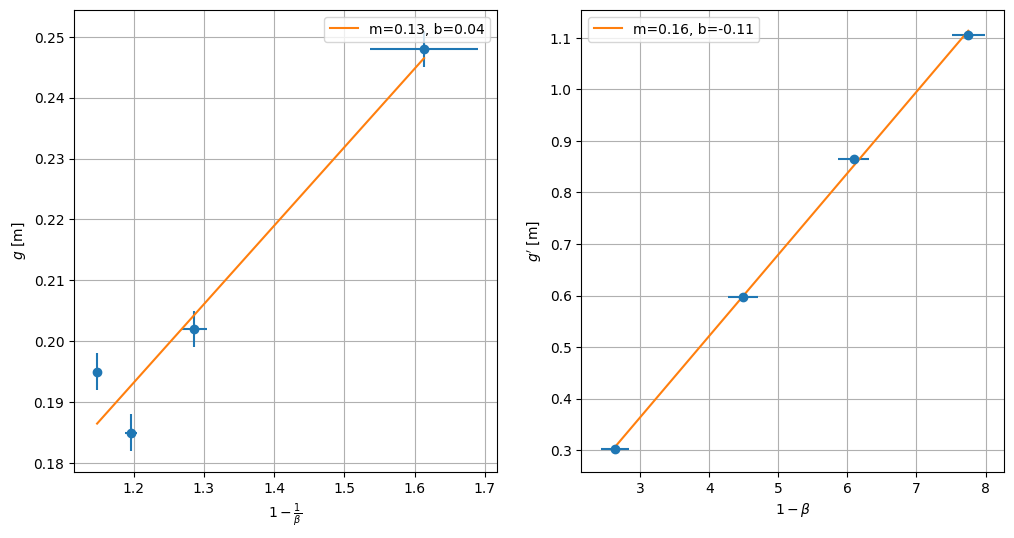

In [377]:
for df, name in [(abbe_e_g, "E-G"), (abbe_g_e, "G-E")]:
    print("------------------------------------------------")
    print(name)
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs = axs.flatten()

    def linear(x, m, b):
        return m * x + b

    # g gegen 1-1/beta
    popt, pcov = curve_fit(
        linear,
        df["1-1/beta_Vergroesserung"],
        df["g_Vergroesserung"],
    )
    print(f"f = {popt[0]:.2f} +- {np.sqrt(pcov[0, 0]):.2f}")
    print(f"h1 = {popt[1]:.2f} +- {np.sqrt(pcov[1, 1]):.2f}")
    axs[0].errorbar(
        df["1-1/beta_Vergroesserung"],
        df["g_Vergroesserung"],
        xerr=df["u_1-1/beta_Vergroesserung"],
        yerr=3e-3,
        fmt="o",
    )
    X = np.linspace(df["1-1/beta_Vergroesserung"].min(), df["1-1/beta_Vergroesserung"].max(), 100)
    axs[0].plot(X, linear(X, *popt), label=f"m={popt[0]:.2f}, b={popt[1]:.2f}")
    axs[0].grid()
    axs[0].legend()
    axs[0].set_xlabel(r"$1 - \frac{1}{\beta}$")
    axs[0].set_ylabel(r"$g$ [m]")

    # g' gegen 1-beta
    popt, pcov = curve_fit(
        linear,
        df["1-beta_Vergroesserung"],
        df["g'_Vergroesserung"],
    )
    print(f"f' = {popt[0]:.2f} +- {np.sqrt(pcov[0, 0]):.2f}")
    print(f"h2 = {popt[1]:.2f} +- {np.sqrt(pcov[1, 1]):.2f}")
    axs[1].errorbar(
        df["1-beta_Vergroesserung"],
        df["g'_Vergroesserung"],
        xerr=df["u_1-beta_Vergroesserung"],
        yerr=3e-3,
        fmt="o",
    )
    X = np.linspace(df["1-beta_Vergroesserung"].min(), df["1-beta_Vergroesserung"].max(), 100)
    axs[1].plot(X, linear(X, *popt), label=f"m={popt[0]:.2f}, b={popt[1]:.2f}")
    axs[1].grid()
    axs[1].legend()
    axs[1].set_xlabel(r"$1 - \beta$")
    axs[1].set_ylabel(r"$g'$ [m]")
    plt.show()